Test out OpenAI's Large Language Model (LLM) API

In [5]:
import openai
import os

key = os.environ.get('OPENAI_API_KEY')
openai.api_key = key

In [5]:
#print(key)

In [6]:
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt="What is the capital of France?",
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

generated_text = response["choices"][0]["text"]
print(generated_text)



Paris


In [10]:
response

<OpenAIObject text_completion id=cmpl-73Z2QF7gPXyztdivs4bDqY0LdLkdA at 0x1f2564d3470> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "\n\nParis"
    }
  ],
  "created": 1681084026,
  "id": "cmpl-73Z2QF7gPXyztdivs4bDqY0LdLkdA",
  "model": "text-davinci-002",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 3,
    "prompt_tokens": 27,
    "total_tokens": 30
  }
}

In [7]:
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt="What is the capital of France? Respond with only the capital. If the provided place has no captial, reply with 'None'",
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

generated_text = response["choices"][0]["text"]
print(generated_text)



Paris


Test out OpenAI's Whisper API - Voice to Text

In [8]:
# FindyBot5000-assets is a separate private github repo. Feel free to add your own assets by modifying the string below.
audio_file= open(r"..\FindyBot5000-assets\audio\test_inputs\FindyBot5000 test audio.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file)

In [9]:
for k,v in transcript.items():
    print(k,v)

text Hello world, this is a test for a FindyBot 5000.


In [11]:
spoken_request = transcript['text']
print(spoken_request)

Hello world, this is a test for a FindyBot 5000.


Test Whisper + LLM. <br>
A spoken command will be along the lines of:<br>
"Hey FindyBot, I'm looking for red leds, can you give me a hand?"
1. Whisper will be used to parse Text from Audio
2. text-davinci LLM will be used to extract the relevant item from the query, in this case 'red led'

In [3]:
def return_searched_item(audio_path: str) -> tuple[str, str]:

    # Whisper
    leds_audio_file= open(audio_path, "rb")
    leds_transcript = openai.Audio.transcribe("whisper-1", leds_audio_file)
    leds_text = leds_transcript['text']

    # text-davinci LLM
    leds_response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"Extract the item I am looking for from the following text. Respond with only the item. Make any plural words or acronyms in the response singular. Here is the text: '{leds_text}'",
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5,
    )

    leds_generated_text = leds_response["choices"][0]["text"]
    return leds_text, leds_generated_text


In [18]:
text, item = return_searched_item(r"..\FindyBot5000-assets\audio\test_inputs\red leds2.mp3")
print(text, item)

Hey Findy Bot, I'm looking for my red LEDs. Can you give me a hand? 

red LEDs


In [4]:
text, item = return_searched_item(r"..\FindyBot5000-assets\audio\test_inputs\AAA batteries.mp3")
print(text, item)

Hey, FinyBot, where are my AAA batteries? 

AAA batteries


Print speech components using PocketSphinx

In [7]:
from pocketsphinx import LiveSpeech
for phrase in LiveSpeech(): print(phrase)

this is a test this is a test on pockets thanks
just one two three
foreign people
find the ball
they do
what
good
are you a beer

this is this from afar

well done



Here's a screenshot of speech recognition with Sphinx. It leaves a little something to be desired...<br>
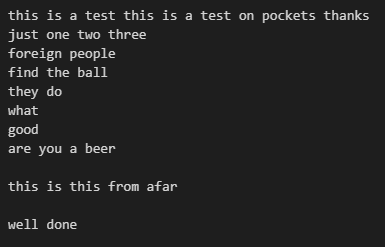

In [10]:
# Lets see how well keywords can be detected.
from pocketsphinx import LiveSpeech

speech = LiveSpeech(lm=False, keyphrase='jarvis', kws_threshold=1e-20)
for phrase in speech:
    print(phrase.segments(detailed=True))

# Jarvis won by a long shot over Aura, Lumen, Aria, Lyra, Zara

[('jarvis', -837, 3, 80)]
[('jarvis', -369, 4, 87)]


In [6]:
import speech_recognition as sr

# Sphinx has some trouble getting 'jarvis' every time...
keywords = ['jarvis', 'jervis']

r = sr.Recognizer()
speech = sr.Microphone(device_index=0)

while True:
    # Listen for a sentence
    with speech as source:
        print("say something!…")
        audio = r.adjust_for_ambient_noise(source)
        audio = r.listen(source)
    
    # First try recognize speech using Sphinx, and search the string for any of the keywords
    # If a keyword is found, pass the raw audio to Whisper to perform full text recognition
    try:
        recognized_text = r.recognize_sphinx(audio)
        
        print("Sphinx thinks you said: '" + recognized_text + "'")

        if any(keyword in recognized_text.lower() for keyword in keywords):
            whisper_text = r.recognize_whisper_api(audio, model="whisper-1", api_key=key)
            print("Whisper thinks you said: '" + whisper_text + "'")

    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  
    except sr.RequestError as e:  
        print("Sphinx error; {0}".format(e))

say something!…
Sphinx thinks you said: 'hey jervis where are my red annuities'
Whisper thinks you said: 'Hey Jarvis, where are my red LEDs?'
say something!…
Sphinx thinks you said: 'the jurors were my trip away batteries'
say something!…
Sphinx thinks you said: 'he jervis where are my triple a. batteries'
Whisper thinks you said: 'Hey Jarvis, where are my AAA batteries?'
say something!…


KeyboardInterrupt: 

Basic end to end example:
1. Listen for a spoken sentence
2. Use Sphinx to determine if the keyword was present
3. If so, use Whisper for speech-to-text
4. Use text-davinci to extract the item that the user is looking for
5. Next up... Synthesize voice from response text

In [ ]:
import speech_recognition as sr

# Sphinx has some trouble getting 'jarvis' every time...
keywords = ['jarvis', 'jervis']

r = sr.Recognizer()
speech = sr.Microphone(device_index=0)

while True:
    # Listen for a sentence
    with speech as source:
        print("Listening for a sentence...")
        audio = r.adjust_for_ambient_noise(source)
        audio = r.listen(source)
    
    # First try recognize speech using Sphinx, and search the string for any of the keywords
    # If a keyword is found, pass the raw audio to Whisper to perform full text recognition
    try:
        recognized_text = r.recognize_sphinx(audio)
        
        print(f"Sphinx thinks you said: '{recognized_text}'")

        # If a keyword wasn't found, go back to listening for input
        if not any(keyword in recognized_text.lower() for keyword in keywords):
            continue

        whisper_text = r.recognize_whisper_api(audio, model="whisper-1", api_key=key)
        print(f"Whisper thinks you said: '{whisper_text}'")
        
        # text-davinci LLM
        openai_response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=f"Extract the item I am looking for from the following text. Respond with only the item. Make any plural words or acronyms in the response singular. Here is the text: '{whisper_text}'",
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
        )

        generated_text = openai_response["choices"][0]["text"]

        print(f"OpenAI thinks you are looking for: '{generated_text}'")

    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  
    except sr.RequestError as e:  
        print("Sphinx error; {0}".format(e))